In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import os
import psutil
import joblib

In [91]:
df = pd.read_csv('phishing_with_features_final.csv')
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
258973,https://www.myspace.com/pauljacksonbass,legitimate,39,15,16,0,False,False,2,0,...,15,0.00,0.0,7,3,0.242424,0.512821,0.000000,0,0
296103,https://www.sportal.co.nz/,legitimate,26,17,1,0,False,False,3,0,...,7,0.00,0.0,7,5,0.157895,0.576923,0.000000,0,0
326386,https://www.xtube.ca/en/,legitimate,24,12,4,0,False,False,2,0,...,5,0.00,0.0,5,2,0.235294,0.625000,0.000000,0,0
54220,https://www.gw2.geneanet.org/lesmascareignes?l...,legitimate,61,20,16,16,False,False,3,0,...,15,0.05,0.0,8,3,0.304348,0.377049,0.058824,0,0
255493,https://www.mylife.com/gertrudepoirier,legitimate,38,14,16,0,False,False,2,0,...,15,0.00,0.0,6,3,0.312500,0.526316,0.000000,0,0


In [92]:
df.isnull().sum()

url                        0
type                       0
url_length                 0
hostname_length            0
path_length                0
query_length               0
has_ip                     0
has_at_symbol              0
count_dots                 0
count_hyphens              0
count_slashes              0
count_underscores          0
count_question_marks       0
count_equals               0
count_ampersands           0
count_digits               0
count_uppercase            0
count_lowercase            0
digit_ratio                0
uppercase_ratio            0
special_char_count         0
subdomain_count            0
max_segment_length         0
avg_segment_length         0
url_entropy                0
hostname_entropy           0
path_entropy               0
uses_https                 0
suspicious_words           0
count_percent              0
count_semicolons           0
count_colons               0
count_brackets             0
count_plus                 0
count_asterisk

In [93]:
df.type.unique()

array(['legitimate', 'phishing'], dtype=object)

In [94]:
df.type = df.type.apply(lambda x: 1 if x=='phishing' else 0)

In [95]:
df.sample(5)

,url,type,url_length,hostname_length,path_length,query_length,has_ip,has_at_symbol,count_dots,count_hyphens,...,max_consecutive_letters,hostname_digit_ratio,path_digit_ratio,domain_length,tld_length,vowel_consonant_ratio,unique_char_ratio,numeric_domain_ratio,shortening_service,suspicious_tld
381924,http://kevinpletcher.com/gmailwebmail.html,1,42,17,18,0,False,False,2,0,...,13,0.0,0.0,13,3,0.277778,0.476190,0.0,0,0
440445,http://henriettezobel.dk/wp-login.php?redirect...,1,93,17,13,55,False,False,4,2,...,14,0.0,0.0,14,2,0.293333,0.290323,0.0,0,0
262549,https://www.newportmansions.org/,0,32,23,1,0,False,False,2,0,...,15,0.0,0.0,15,3,0.230769,0.500000,0.0,0,0
426479,http://www.venetianbanquetcentre.com/modules/m...,1,75,29,39,0,False,False,3,0,...,21,0.0,0.0,21,3,0.285714,0.333333,0.0,0,0
292764,https://www.sonicelectronix.com/alfa_romeo-car...,0,60,23,29,0,False,False,3,2,...,15,0.0,0.0,15,3,0.320000,0.366667,0.0,0,0


In [96]:
df.drop(columns=['url'], inplace=True, errors='ignore')

# Integer columns (counts and lengths)
int_cols = ['url_length', 'hostname_length', 'path_length', 'query_length',
            'count_dots', 'count_hyphens', 'count_slashes', 'count_underscores',
            'count_question_marks', 'count_equals', 'count_ampersands', 
            'count_digits', 'count_uppercase', 'count_lowercase',
            'special_char_count', 'subdomain_count', 'max_segment_length',
            'suspicious_words', 'count_percent', 'count_semicolons', 
            'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
            'path_depth', 'query_params', 'max_consecutive_digits',
            'max_consecutive_letters', 'domain_length', 'tld_length']

for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

# Boolean columns
bool_cols = ['has_ip', 'has_at_symbol', 'uses_https', 'shortening_service', 'suspicious_tld']

for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype('bool')

# Float columns (ratios and entropy values)
float_cols = ['digit_ratio', 'uppercase_ratio', 'avg_segment_length',
              'url_entropy', 'hostname_entropy', 'path_entropy',
              'hostname_digit_ratio', 'path_digit_ratio', 
              'vowel_consonant_ratio', 'unique_char_ratio', 'numeric_domain_ratio']

for col in float_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

In [97]:
df.dtypes

type                         int64
url_length                   int16
hostname_length              int16
path_length                  int16
query_length                 int16
has_ip                        bool
has_at_symbol                 bool
count_dots                    int8
count_hyphens                 int8
count_slashes                 int8
count_underscores            int16
count_question_marks         int16
count_equals                  int8
count_ampersands              int8
count_digits                 int16
count_uppercase              int16
count_lowercase              int16
digit_ratio                float32
uppercase_ratio            float32
special_char_count           int16
subdomain_count               int8
max_segment_length            int8
avg_segment_length         float32
url_entropy                float32
hostname_entropy           float32
path_entropy               float32
uses_https                    bool
suspicious_words              int8
count_percent       

In [98]:
class_count0, class_count1 = df['type'].value_counts()
class_count0, class_count1

(345738, 104438)

In [99]:
X= df.drop('type', axis=1)
y = df['type']

In [100]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [101]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
y_train_resampled.value_counts()

type
1    259303
0    259303
Name: count, dtype: int64

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def tune_phishing_models(X_train, y_train, scoring='accuracy', cv=5, verbose=0):
    models_params = {
        'Logistic Regression': {
            'model': LogisticRegression(max_iter=500),
            'params': {
                'model__C': [0.1, 1, 10],
                'model__penalty': ['l2'],
                'model__solver': ['lbfgs']
            }
        },
        # 'Naive Bayes': {
        #     'model': GaussianNB(),
        #     'params': {}  # no tuning needed
        # },
        # 'Linear SVM': {
        #     'model': LinearSVC(max_iter=1000),
        #     'params': {
        #         'model__C': [0.1, 1, 10]
        #     }
        # }
    }

    best_models = {}

    for name, config in models_params.items():
        print(f"\n🔍 Tuning: {name}")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', config['model'])
        ])

        grid = GridSearchCV(
            pipeline,
            config['params'],
            cv=cv,
            scoring=scoring,
            verbose=verbose,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)

        print(f"✅ {name} best score: {grid.best_score_:.4f}")
        print(f"🔧 Best params: {grid.best_params_}")
        best_models[name] = grid.best_estimator_

    return best_models

In [105]:
tune_phishing_models(X_train_scaled, y_train_resampled) 


🔍 Tuning: Logistic Regression
✅ Logistic Regression best score: 0.9912
🔧 Best params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


{'Logistic Regression': Pipeline(steps=[('scaler', StandardScaler()),
                 ('model', LogisticRegression(C=10, max_iter=500))])}

In [106]:
model = LogisticRegression(C=10, penalty='l2', solver='lbfgs', verbose=0)

In [107]:
model.fit(X_train_scaled, y_train_resampled)

C:\Users\sinan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [108]:
model.score(X_test_scaled, y_test)

0.9940645436451521

In [109]:
y_predicted = model.predict(X_test_scaled)

In [110]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86435
           1       0.99      0.98      0.99     26109

    accuracy                           0.99    112544
   macro avg       0.99      0.99      0.99    112544
weighted avg       0.99      0.99      0.99    112544



In [111]:
y_probs = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Change threshold
threshold = 0.43  # Try 0.4 or even 0.3
y_pred_adjusted = (y_probs >= threshold).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_adjusted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86435
           1       0.99      0.99      0.99     26109

    accuracy                           0.99    112544
   macro avg       0.99      0.99      0.99    112544
weighted avg       0.99      0.99      0.99    112544



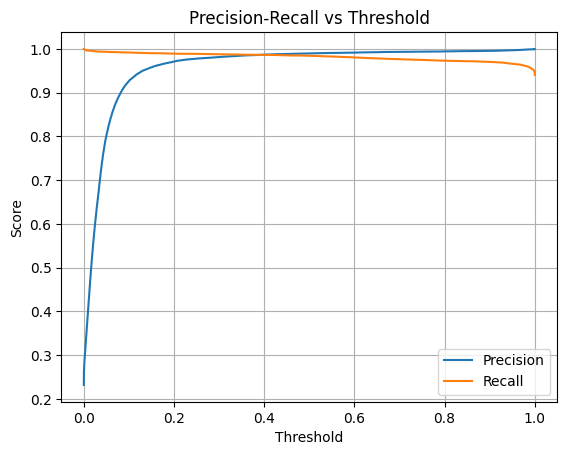

In [112]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)

In [113]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Filter where precision is at least 0.75
mask = precision[:-1] >= 0.75  # exclude the last threshold (no corresponding value)
filtered_thresholds = thresholds[mask]
filtered_recalls = recall[:-1][mask]

# Find threshold with maximum recall
if len(filtered_thresholds) > 0:
    best_idx = np.argmax(filtered_recalls)
    best_threshold = filtered_thresholds[best_idx]
    best_recall = filtered_recalls[best_idx]
    best_precision = precision[:-1][mask][best_idx]
    print(f"Best threshold: {best_threshold:.2f} with precision: {best_precision:.2f}, recall: {best_recall:.2f}")
else:
    print("No threshold found with precision >= 0.75")


Best threshold: 0.04 with precision: 0.75, recall: 0.99


In [114]:
joblib.dump(model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [115]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
background_data = X_train_scaled_df.sample(n=500, random_state=42)
background_data.to_csv("shap_background.csv")

In [116]:
X_train_scaled[:2]

array([[-0.4492834 , -0.6489945 , -0.27768448, -0.21509846, -0.13876878,
        -0.12997864, -1.0807016 , -0.4341171 , -0.32242018, -0.2848693 ,
        -0.3530344 , -0.28930125, -0.16986519, -0.26012468, -0.10369204,
        -0.49952626, -0.1608343 ,  0.01763125,  0.0598347 , -1.2088159 ,
         0.07513522,  0.24933873,  0.5960295 ,  0.00715048,  0.4805123 ,
        -1.0827192 , -0.22325253,  0.6082263 , -0.11634927, -0.1210725 ,
        -0.07281241, -0.09906927, -0.00952434, -0.13149805, -0.27889544,
        -0.07260519, -0.04716162, -0.2335685 ,  0.1395819 ,  0.16257435,
        -1.0802006 , -0.06349879,  1.3582549 , -0.22330509, -0.2556622 ,
        -0.07291985],
       [ 0.4052147 ,  0.43711677,  0.9242881 , -0.21509846, -0.13876878,
        -0.12997864, -0.37333798,  2.2732406 , -0.32242018, -0.2848693 ,
        -0.3530344 , -0.28930125, -0.16986519, -0.4244795 , -0.1802945 ,
         0.9393861 , -0.6716428 , -0.4285961 , -0.2241128 ,  0.11240432,
         0.6654601 ,  0.32440

In [117]:
X_train.columns

Index(['url_length', 'hostname_length', 'path_length', 'query_length',
       'has_ip', 'has_at_symbol', 'count_dots', 'count_hyphens',
       'count_slashes', 'count_underscores', 'count_question_marks',
       'count_equals', 'count_ampersands', 'count_digits', 'count_uppercase',
       'count_lowercase', 'digit_ratio', 'uppercase_ratio',
       'special_char_count', 'subdomain_count', 'max_segment_length',
       'avg_segment_length', 'url_entropy', 'hostname_entropy', 'path_entropy',
       'uses_https', 'suspicious_words', 'count_percent', 'count_semicolons',
       'count_colons', 'count_brackets', 'count_plus', 'count_asterisk',
       'path_depth', 'query_params', 'max_consecutive_digits',
       'max_consecutive_letters', 'hostname_digit_ratio', 'path_digit_ratio',
       'domain_length', 'tld_length', 'vowel_consonant_ratio',
       'unique_char_ratio', 'numeric_domain_ratio', 'shortening_service',
       'suspicious_tld'],
      dtype='object')

In [118]:
X_train.shape

(337632, 46)

Text(0.5, 36.72222222222221, 'Predicted Label')

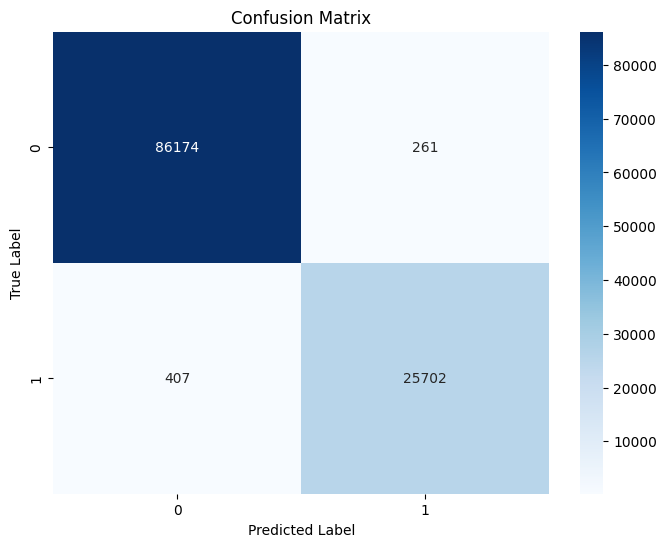

In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_adjusted=model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')